# Demo 01: Echogram fu
### `themachinethatgoesping` tutorial series

Here we show how to create echograms from acoustic data and how to do magic with them

In [1]:
%matplotlib widget

import numpy as np
import themachinethatgoesping as theping
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import os

# Open Datasets

In [2]:
# data folder
folder = r'/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/PLUME_0/'

all_pings_by_channel = {}
theping.pingprocessing.core.clear_memory()

## EK80

In [3]:
# find all simrad files in the list of folders
files = sorted(theping.echosounders.index_functions.find_files(folder,['.raw']))
cache_files = theping.echosounders.index_functions.get_index_paths(files)

# create the file handler
fh_sbes = theping.echosounders.simradraw.SimradRawFileHandler(files, cache_files)

# get pings that contain WCD
pings_sbes = theping.pingprocessing.filter_pings.by_features(fh_sbes.get_pings(),['watercolumn.amplitudes'])

# split pings by channel and add to all_pings_by_channel
all_pings_by_channel.update( theping.pingprocessing.split_pings.by_channel_id(pings_sbes))

Found 50 files
indexing files ⠂ 99% :00s<00m:00s] [Found: 1881429 datagrams in 50 files (23769MB)]                                                
Initializing ping interface ⠁ 99% :11s<00m:00s] [Done]                                              


## EM2040

In [4]:
# find all Kongsberg files in the list of folders
files = sorted(theping.echosounders.index_functions.find_files(folder,['.all', '.wcd']))
cache_files = theping.echosounders.index_functions.get_index_paths(files)

# create the file handler
fh_mbes = theping.echosounders.kongsbergall.KongsbergAllFileHandler(files, cache_files)

# get pings that contain WCD
pings_mbes = theping.pingprocessing.filter_pings.by_features(fh_mbes.get_pings(),['watercolumn.amplitudes'])

# split pings by channel and add to pings_by_channel
all_pings_by_channel.update(theping.pingprocessing.split_pings.by_channel_id(pings_mbes))

Found 139 files
indexing files ⠄ 99% :00s<00m:00s] [Found: 2647276 datagrams in 139 files (54527MB)]                                                 
Initializing ping interface ⠄ 98% :06s<00m:00s] [Done]                                                                             


In [5]:
#show keys in all_pings_by_channel
all_pings_by_channel.keys()

dict_keys(['WBT 400051-15 ES120-7C_ES', 'WBT 400038-15 ES18_ES', 'WBT 400052-15 ES200-7C_ES', 'WBT 400040-15 ES38-7_ES', 'WBT 400058-15 ES333-7C_ES', 'WBT 400050-15 ES70-7C_ES', 'TRX-2004', 'TRX-2031'])

# Get overview

In [6]:
#use this transducer to create 'stations'

base_key = 'WBT 400058-15 ES333-7C_ES'

#split data when there is more than 60 seconds between two pings
ek80_per_station = theping.pingprocessing.split_pings.by_time_difference(all_pings_by_channel[base_key], 60)
ek80_per_station.keys()

dict_keys([0, 1, 2, 3])

plotting overview for pings: Done    


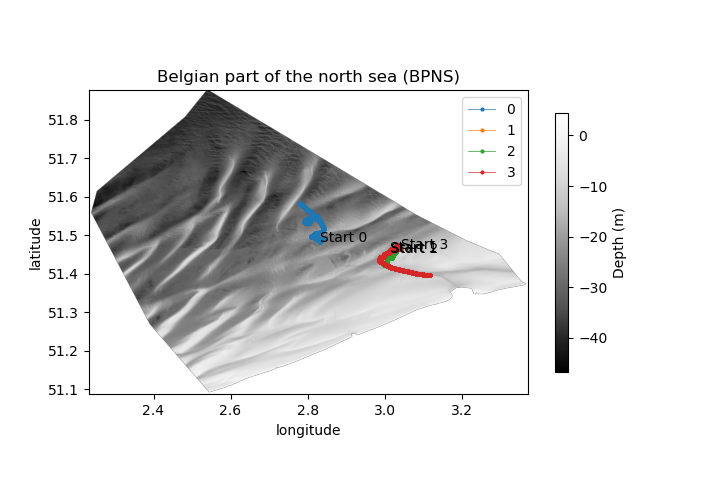

In [7]:
fig, ax = theping.pingprocessing.overview.nav_plot.create_figure(
#fig, ax = create_figure(
    "Belgian part of the north sea (BPNS)", 
    aspect="equal", 
    background_image_path=os.path.join(folder,"BPNS_latlon.tiff"), 
    background_colorbar_label='Depth (m)',
    colorbar_orientation='vertical',
    add_grid=False,
    cmap="Greys_r"
)

stats = theping.pingprocessing.overview.get_ping_overview(ek80_per_station)

for k,v in stats.items():
    v.plot_navigation(ax, label=k)

print(f"plotting overview for pings: Done    ")
ax.legend()

fig.set_figwidth(3.34646) #85mm
fig.set_figwidth(7.08661) #180mm

In [8]:
# sort pings per channel to each stations (using ek80_per_station as base to define stations)
from collections import defaultdict

pings_by_station_by_channel = defaultdict(dict)

for station,base_pings in tqdm(ek80_per_station.items()):
    for channel, pings in tqdm(all_pings_by_channel.items()):
        pings_by_station_by_channel[station][channel] = theping.pingprocessing.filter_pings.by_ping_times(pings, base_pings)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
print("stations:", pings_by_station_by_channel.keys())
print("channels:", pings_by_station_by_channel[1].keys())

stations: dict_keys([0, 1, 2, 3])
channels: dict_keys(['WBT 400051-15 ES120-7C_ES', 'WBT 400038-15 ES18_ES', 'WBT 400052-15 ES200-7C_ES', 'WBT 400040-15 ES38-7_ES', 'WBT 400058-15 ES333-7C_ES', 'WBT 400050-15 ES70-7C_ES', 'TRX-2004', 'TRX-2031'])


In [21]:
# selection station and channels to display / export
station = 3

channels = [
    'TRX-2004', 
    #'TRX-2031',
    #'WBT 400038-15 ES18_ES', 
    #'WBT 400040-15 ES38-7_ES', 
    #'WBT 400050-15 ES70-7C_ES', 
    #'WBT 400051-15 ES120-7C_ES', 
    #'WBT 400052-15 ES200-7C_ES', 
    'WBT 400058-15 ES333-7C_ES', 
]

pings_by_channel = defaultdict(list)

for channel in channels:
    pings_by_channel[channel].extend(pings_by_station_by_channel[station][channel])

# create echograms from the data

In [22]:
echogram_data = {}

# for multibeam data only stack beams between -3 and +3° beam angle
pss = theping.echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-3,3)

# go through all channels and create an echogram builder for the channel
for k,pings in tqdm(pings_by_channel.items()):
    
    echogram_data[k] = theping.pingprocessing.watercolumn.echograms.EchogramBuilder.from_pings(
        pings,
        pss=pss,
        wci_value = 'av',
        linear_mean=False,
        verbose=False)


#set minslant parameter
for k,e in tqdm(echogram_data.items()):
    e.set_x_axis_date_time(max_steps=2000)
    e.set_y_axis_depth()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# Display echogram using echogram viewer

In [23]:
pingviewer = theping.pingprocessing.widgets.WCIViewer(theping.pingprocessing.group_pings.dual_head(pings_mbes))

In [24]:
echogramviewer = theping.pingprocessing.widgets.EchogramViewer(echogram_data)
echogramviewer.connect_pingviewer(pingviewer)

# Read and process CSV file as layer

In [32]:
#set ctd depth offset
import pandas as pd

csv_data = pd.read_csv(os.path.join(folder,'csv/ST2227_SBE09_2.csv'))
print(csv_data.iloc[0:5]['DepSM'])
                       
ctd_depth_offset = 0.8 #will be added
ctd_depth_offset = 2

0   -0.737
1   -0.793
2   -0.713
3   -0.737
4   -0.737
Name: DepSM, dtype: float64


In [33]:
#read ctd table
csv_data = pd.read_csv(os.path.join(folder,'csv/ST2227_SBE09_2.csv'))
csv_data['Datetime'] = pd.to_datetime(csv_data['Datetime'],utc=True, dayfirst=True)
csv_data = csv_data.set_index('Datetime')
csv_data['DepSM'] += ctd_depth_offset # depth offset ctd
#csv_data


In [34]:
#create table with only numeric data, resample to 1second and add as layer to the echograms
data_vals = csv_data.copy()
del data_vals['Vessel']
del data_vals['Plume']
del data_vals['Activity']
data_vals = data_vals[data_vals['DepSM'] > 0]
data_vals = data_vals.resample('1s').mean().dropna()

for e in echogramviewer.echogramdata:
    e.clear_layers()
    e.add_layer('ctd',data_vals.index, data_vals['DepSM']-0.5,data_vals['DepSM']+0.5)

#data_vals
#you can now press update in the echogramviewer

In [35]:
#extract average from echograms

from collections import defaultdict
import datetime
import pandas as pd

T= defaultdict(list)
V= defaultdict(list)
W= defaultdict(list)
data = defaultdict(pd.DataFrame)
for i,e in enumerate(tqdm(echogramviewer.echogramdata)):
    name = echogramviewer.names[i]
    try:
        for p in tqdm(list(e.iterate_ping_data(True))):
            e0,e1 = p.get_extent_layers()['ctd']
            l0,l1 = p.get_limits_layers()['ctd']
            if e0 == e1:
                continue
        
            T[name].append(datetime.datetime.fromtimestamp(p.get_ping_time(), tz=datetime.timezone.utc))
            wci = p.get_wci_layers_range_stack()['ctd']
            V[name].append(wci)
            W[name].append(np.mean(wci))
    except:
        pass

    data[name]['time'] = pd.to_datetime(T[name])
    data[name][f'mean sv - {name}'] = W[name]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1322 [00:00<?, ?it/s]

  0%|          | 0/1060 [00:00<?, ?it/s]

/ssd/src/themachinethatgoesping/tutorials/.pixi/envs/default/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

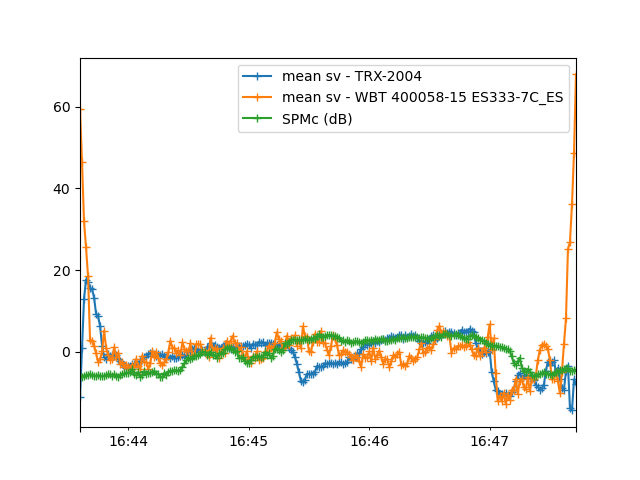

In [38]:
# merge data and plot
time_step = '1s'

merged_df = []
for name,d in data.items():
    merged_df.append(data[name].set_index('time').resample(time_step).mean())

data_vals = csv_data.copy()
data_vals = data_vals[data_vals['DepSM'] > 0]
data_vals = data_vals[['SPMc']]
data_vals['SPMc (dB)']=10*np.log10(data_vals['SPMc'])
data_vals = data_vals.resample(time_step).mean().dropna()
merged_df.append(data_vals)

merged_df_ = merged_df
merged_df = []
for df in merged_df_:
    if len(df) >0:
        merged_df.append(df)

merged_df = pd.concat(merged_df,axis=1).dropna()

merged_df_ = merged_df.copy()
del merged_df_['SPMc']
for k in merged_df_.keys():
    merged_df_[k]-=np.nanmedian(merged_df_[k])


merged_df_.plot(marker='+')

In [37]:
merged_df.to_csv(f'station({station})-layer-averages.csv')

In [ ]:
#merged_df

In [ ]:
import datetime

#modify max_depth if necessary
max_depth = 30 #m
time_resolution = 1 #s (subsampled not averaged)

#take min/max from merged_df
t0 = merged_df.index[0] - datetime.timedelta(minutes=5)
t1 = merged_df.index[-1] + datetime.timedelta(minutes=5)

In [ ]:
import importlib
import functions.util as util
importlib.reload(util)

#set minslant parameter
for k,e in tqdm(echogram_data.items()):
    #set maximum resolution
    e.set_x_axis_date_time(max_steps=100000,time_resolution=time_resolution, min_ping_time=t0.timestamp(), max_ping_time=t1.timestamp())
    e.set_y_axis_depth(max_steps=51200, max_depth=max_depth)

    # create image
    image, extent = e.build_image(progress=True)
    xim = util.image_to_xarray(image,extent,xdim='Ping time', ydim='Depth(m)')
    
    xim.to_netcdf(f'station({station})-{k}.nc', format='NETCDF4', engine="netcdf4")
    
    e.set_x_axis_date_time(max_steps=4000)
    e.set_y_axis_depth(max_steps=512, max_depth=30)

In [ ]:
t1-t0